In [19]:
import requests
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
import matplotlib.pyplot as plt
import time

api_key = "87fff5f5ea2e868e7e0332a9839713c2"

In [23]:
def get_movie_data(pages=10):
    movie_data = []
    for page in range(1, pages+1):
        url = f"https://api.themoviedb.org/3/discover/movie?api_key={api_key}&sort_by=popularity.desc&page={page}&primary_release_date.gte=2000-01-01"
        response = requests.get(url)
        results = response.json().get('results', [])
        
        for movie in results:
            try:
                movie_id = movie['id']
                detail_url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}&append_to_response=credits"
                detail = requests.get(detail_url).json()
                
                genres = [g['name'] for g in detail.get('genres', [])]
                cast = [c['name'] for c in detail.get('credits', {}).get('cast', [])[:3]]
                movie_data.append({
                    'title': detail.get('title'),
                    'year': int(detail.get('release_date', '2000')[:4]),
                    'runtime': detail.get('runtime'),
                    'genres': genres,
                    'cast': cast,
                    'vote_average': detail.get('vote_average'),
                    'popularity': detail.get('popularity')
                })
                
                time.sleep(0.25)
            except Exception as e:
                print("Skipped one due to error:", e)
    return pd.DataFrame(movie_data)

df = get_movie_data(pages=10)
df.dropna(subset=['runtime', 'vote_average'], inplace=True)

In [24]:
mlb_genres = MultiLabelBinarizer()
mlb_cast = MultiLabelBinarizer()

genres_encoded = pd.DataFrame(mlb_genres.fit_transform(df['genres']), columns=mlb_genres.classes_)
top_cast = pd.Series([c for sublist in df['cast'] for c in sublist]).value_counts().nlargest(20).index.tolist()
df['cast'] = df['cast'].apply(lambda c: [actor for actor in c if actor in top_cast])
cast_encoded = pd.DataFrame(mlb_cast.fit_transform(df['cast']), columns=mlb_cast.classes_)


In [25]:
df_combined = pd.concat([df.drop(columns=['title', 'genres', 'cast']), genres_encoded, cast_encoded], axis=1)

scaler = MinMaxScaler()
df_combined[['runtime', 'year', 'popularity']] = scaler.fit_transform(df_combined[['runtime', 'year', 'popularity']])


In [26]:
X = df_combined.drop(columns=['vote_average'])
y = df_combined['vote_average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [33]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

R² Score: -0.083
RMSE: 1.401


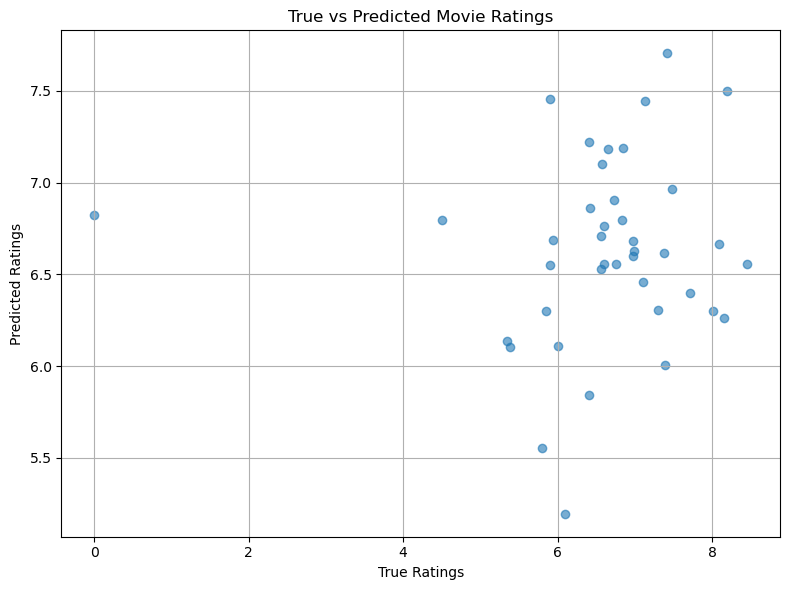

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("True Ratings")
plt.ylabel("Predicted Ratings")
plt.title("True vs Predicted Movie Ratings")
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
errors = np.abs(y_test - y_pred)
top_mistakes = pd.DataFrame({
    'True Rating': y_test,
    'Predicted Rating': y_pred,
    'Error': errors
}).sort_values(by='Error', ascending=False).head(5)

print("\nTop 5 Misclassified Samples:")
print(top_mistakes)


Top 5 Misclassified Samples:
     True Rating  Predicted Rating    Error
135        0.000           6.82413  6.82413
150        4.500           6.79643  2.29643
152        8.455           6.55415  1.90085
104        8.148           6.25964  1.88836
164        8.009           6.30186  1.70714
